**This basic lane detection project sees the use of color selection, region of interest selection, grayscaling, Gaussian smoothing, Histogram equalization, Canny Edge Detection and Hough Tranform line detection.  
These tools are used to piece together a pipeline to detect the line segments in an image, then average/extrapolate them and draw them onto the image for display.**

In [12]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from IPython.display import Image
from IPython.display import display

In [47]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#return lines for final picture overlay 
def pic_overlay(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    slopes = {}
    slopes['neg'] = []
    slopes['pos'] = []
    #slopes['neg_slope'] = []
    #slopes['pos_slope'] = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            #find slope and add to dict, if slope is negative add to right or if positive left line
            if (y2-y1) != 0 and (x2-x1) !=0:
                slope = (y2-y1)/(x2-x1)
                if slope > 0.2 and slope < 2:
                    slopes['neg'].append([x1,y1,x2,y2])
                    #slopes['neg_slope'].append(slope)
                elif slope < -0.2 and slope >-2:
                    slopes['pos'].append([x1,y1,x2, y2])
                    #slopes['pos_slope'].append(slope)
                
    ##################Using polyfit line########################
    #####pos slope
    if len(slopes['pos']) > 0:
        pos_xh = [x[0] for x in slopes['pos']]
        pos_yh = [y[1] for y in slopes['pos']]
        pos_slope, pos_b = np.polyfit(pos_xh, pos_yh, 1) 
    else:
        pos_slope, pos_b = 0, 0
    
    #####neg slope
    if len(slopes['neg'])>0:
        neg_xh = [xx[2] for xx in slopes['neg']]
        neg_yh = [yy[3] for yy in slopes['neg']]
        neg_slope, neg_b = np.polyfit(neg_xh, neg_yh, 1)
    else:
        neg_slope, neg_b = 0, 0
    ############################################################
    
    #Line for regression
    Y1 = img.shape[0]
    Y2 = 330

    if pos_slope!=0 and neg_slope!=0:
        #for right lane
        X12 = int((Y1-pos_b)/pos_slope)
        X22 = int((Y2-pos_b)/pos_slope)
        #for left lane
        X1 = int((Y1-neg_b)/neg_slope)
        X2 = int((Y2-neg_b)/neg_slope)
    else:
        X12 = 0
        X22 = 0
        X1 = 0
        X2 = 0
  
    #Stop integer overflow in video stream
    #left lane
    if abs(X1) > 2*img.shape[1] and X1>0: 
        X1 = 2*img.shape[1] 
    elif abs(X1) > 2*img.shape[1] and X1<0: 
        X1 = -2*img.shape[1]
    
    if abs(X2) > 2*img.shape[1] and X2>0: 
        X2 = 2*img.shape[1] 
    elif abs(X2) > 2*img.shape[1] and X2<0: 
        X2 = -2*img.shape[1]
        
    #right lane
    if abs(X12) > 2*img.shape[1] and X12>0: 
        X12 = 2*img.shape[1] 
    elif abs(X12) > 2*img.shape[1] and X12<0: 
        X12 = -2*img.shape[1]
    
    if abs(X22) > 2*img.shape[1] and X22>0: 
        X22 = 2*img.shape[1] 
    elif abs(X22) > 2*img.shape[1] and X22<0: 
        X22 = -2*img.shape[1]
        
    #blank image shape    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    #left lane
    cv2.line(line_img, (X12, Y1), (X22, Y2), color=[255, 0, 0],thickness=10)
    #right lane
    cv2.line(line_img, (X1, Y1), (X2, Y2), color=[255, 0, 0],thickness=10)
    
    #print([X1, X2, X12, X22])
    return line_img

def color_filter(img):
    '''Takes in an image and returns only yellow and white regions only using hsv filters'''
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([190,255,255])

    lower_white = np.array([0, 0, 130])
    upper_white = np.array([70, 70, 255]) 
     
    #Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow) # I have the Green threshold image.
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    mask = yellow_mask + white_mask

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)
    #plt.imshow(grayscale(res), cmap = 'gray')
    
    return res
    

In [2]:
#Find colors for HSV filter
#[H-10, 100,100] and [H+10, 255, 255]
white = np.uint8([[[255,255,255]]])
hsv_white = cv2.cvtColor(white,cv2.COLOR_BGR2HSV)
print(hsv_white)

yellow = np.uint8([[[255,255,0]]])
hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
print(hsv_yellow)

[[[  0   0 255]]]
[[[ 90 255 255]]]


In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve_with_lanes.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2_with_lanes.jpg',
 'solidWhiteRight_with_lanes.jpg',
 'whiteCarLaneSwitch_with_lanes.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft_with_lanes.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

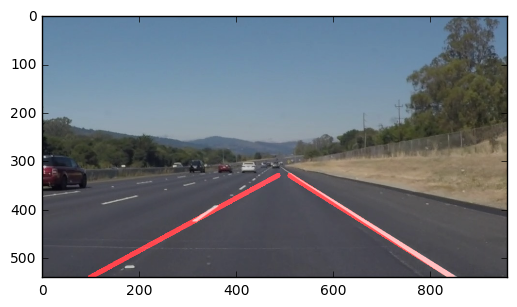

In [17]:
import numpy as np
#reading in image
image0 = mpimg.imread('test_images/solidWhiteRight.jpg')
image1 = mpimg.imread('test_images/solidYellowCurve.jpg') 
image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
image3 = mpimg.imread('test_images/solidYellowCurve2.jpg') 
image4 = mpimg.imread('test_images/solidYellowLeft.jpg') 
#apply color filter for white and yellow lines
image = image0
img = color_filter(image)
#greyscale image
gray = grayscale(img)
#plt.imshow(gray, cmap = 'gray')
#histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

#apply Gaussian blur
gaus_gray = gaussian_blur(cl1, 3)

#apply canny edge detection
can_gray = canny(gaus_gray, low_threshold=50, high_threshold=100)

#plt.imshow(can_gray, cmap = 'gray')
#apply image segmentation
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 340), (490, 340), (imshape[1],imshape[0])]], dtype=np.int32)
reg_gray = region_of_interest(can_gray, vertices = vertices)

#apply image augmentation
lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=3, min_line_len=5, max_line_gap=1)

#apply line extrapolation on hough_coord
draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)

plt.imsave('whiteCarLaneSwitch_with_lanes.jpg', draw_lanes)
plt.imshow(draw_lanes)

## Test on Videos

The above solutions to still images are then applied to .mp4 videos of actual driving footage.

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [18]:
import imageio
imageio.plugins.ffmpeg.download()

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process_image(image):
    #pipeline
    #gray scale -> histogram equalization ->gaussian blur -> canny detection -> ROI -> Hough -> Lane drawing
    
    #apply color filter for white and yellow lines
    img = color_filter(image)
    
    #greyscale image
    gray = grayscale(img)
    #plt.imshow(gray, cmap = 'gray')
    
    #histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #apply Gaussian blur
    gaus_gray = gaussian_blur(cl1, 7)

    #apply canny edge detection
    can_gray = canny(gaus_gray, low_threshold=100, high_threshold=150)

    #plt.imshow(can_gray, cmap = 'gray')
    #apply image segmentation
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 300), (490, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    reg_gray = region_of_interest(can_gray, vertices = vertices)

    #apply image augmentation
    lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=1, min_line_len=10, max_line_gap=1)

    #apply line extrapolation on hough_coord
    draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)
    return draw_lanes

Let's try the one with the solid white lane on the right first ...

In [21]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 13.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 29.6 s, sys: 920 ms, total: 30.5 s
Wall time: 17 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [49]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:01<00:00, 11.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 48s, sys: 4.92 s, total: 1min 53s
Wall time: 1min 2s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections


The final project pipeline is summarized as:
    image extraction -> rgb to hsv conversion -> white and yellow filter-> trapezoid section of interest extracted -> canny edge detection -> hough-transform to id straight lines-> straight line extrapolation from filtered slopes-> image overlay with straightline

There are a couple of things I could've done to improve the results:

    1. optimize all the different algorithms:
    I found it difficult to optimize all the different parameters to generalize all the different lighting conditions. Perhaps this would've stopped some of the dramatic dotted lane jumps.
    
    2. Find an adequate color picker to help make an effective color mask to separate white and yellow hues.
    
    3. Use a frame buffer to stop the jittery lane overalays - however this could be done at a later stage in the pipeline whilst considering other factors/sensory data.
 
All in all this was an interesting project and taught me how to fine tune and troubleshoot different opencv packages and apply them to actual video data.